In [9]:
from river import datasets

#in the dataset, all the features except day are normalized
elec = datasets.Elec2() #load dataset

In [10]:
import matplotlib.pyplot as plt
from river import tree, preprocessing, compose, stats
from river.evaluate import progressive_val_score
from river.metrics import Accuracy
import pandas as pd
from sklearn.metrics import f1_score
from itertools import islice
from sklearn.metrics import auc

In [11]:
#look at one sample
x, y = next(iter(elec))
print(x, y)

{'date': 0.0, 'day': 2, 'period': 0.0, 'nswprice': 0.056443, 'nswdemand': 0.439155, 'vicprice': 0.003467, 'vicdemand': 0.422915, 'transfer': 0.414912} True


   date  day    period  nswprice  nswdemand  vicprice  vicdemand  transfer  \
0   0.0    2  0.000000  0.056443   0.439155  0.003467   0.422915  0.414912   
1   0.0    2  0.021277  0.051699   0.415055  0.003467   0.422915  0.414912   
2   0.0    2  0.042553  0.051489   0.385004  0.003467   0.422915  0.414912   
3   0.0    2  0.063830  0.045485   0.314639  0.003467   0.422915  0.414912   
4   0.0    2  0.085106  0.042482   0.251116  0.003467   0.422915  0.414912   

   label  
0   True  
1   True  
2   True  
3   True  
4  False  


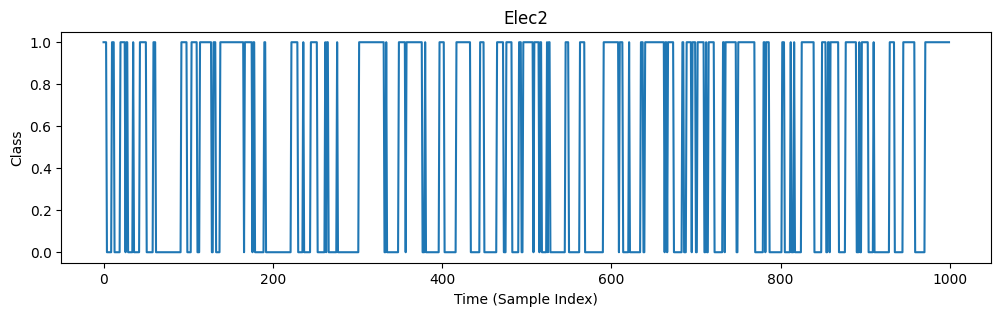

In [12]:
df = pd.DataFrame((x | {'label': y} for x, y in elec.take(1000)))
print(df.head())

plt.figure(figsize=(12,3))
plt.plot(df.index, df['label'].astype(int))
plt.title("Elec2")
plt.xlabel("Time (Sample Index)")
plt.ylabel('Class')
plt.show()

          0         1         2         3         4         5         6  \
t                                                                         
0  0.370553 -0.034558  0.894524  0.925527  1.035873  1.074798  0.692361   
1  0.368997  0.896632  0.454175  0.249430  0.061418  0.022750  0.557938   
2  0.665597  0.227113  1.090868 -0.060357  0.322763  1.092873  1.055710   
3  0.816490 -0.386625  0.184813  0.811755  0.086882  0.827578  0.221706   
4  0.987059  0.590174  0.550704  0.764953  0.067961  0.600298  0.511821   

          7  y  
t               
0  0.136760  1  
1  0.583386  0  
2 -0.341307  1  
3  0.504505  0  
4  0.847238  0  


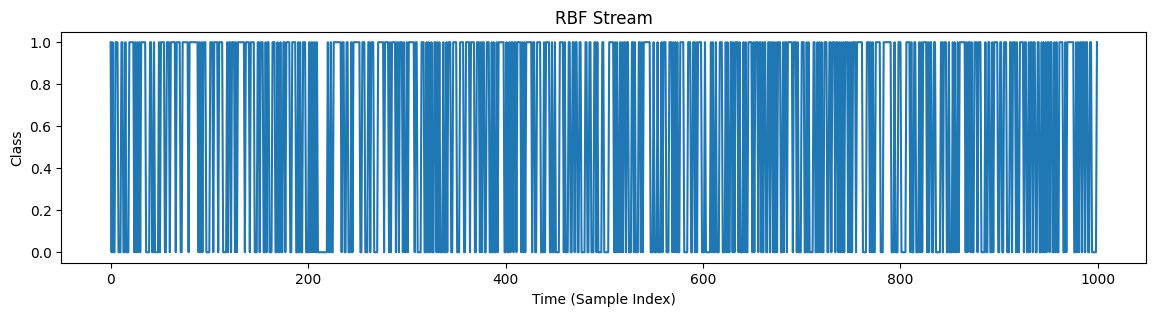

In [13]:
from river.datasets import synth

syn_stream = synth.RandomRBFDrift(
    n_classes=2,
    n_features=8,
    n_centroids=30,
    n_drift_centroids=15,
    change_speed=0.001,
    seed_model=42,
    seed_sample=42
)


rows = []
for i, (x, y) in enumerate(syn_stream.take(1000)):
    row = x.copy()       
    row['y'] = y         
    row['t'] = i      
    rows.append(row)

df = pd.DataFrame(rows).set_index('t')
print(df.head())

plt.figure(figsize=(14, 3))
plt.plot(df.index, df['y'])
plt.title('RBF Stream')
plt.xlabel('Time (Sample Index)')
plt.ylabel('Class')
plt.show()

In [14]:
def train_evaluate(stream,model):
    steps = []
    accs  = []
    n_samples = 0

    metric = Accuracy()
    stream = iter(stream)
    init_batch = list(islice(stream, 1000))

    for x, y in init_batch:
        model.learn_one(x, y)
        n_samples += 1

    for x, y in islice(stream, 45312 - n_samples):
        y_p = model.predict_one(x)
        if y_p is not None:
            metric.update(y_true=y, y_pred=y_p)

        model.learn_one(x, y)
        n_samples += 1

        if n_samples % 1000 == 0:
            steps.append(n_samples)
            accs.append(metric.get())
           

    print("Final accuracy:", metric.get())
    auc_norm_syn = auc(steps,accs) / (steps[-1] - steps[0])
    print('Normalized AUC:', auc_norm_syn)

    plt.figure(figsize=(6, 4))
    plt.plot(steps, accs, marker=".")
    plt.xlabel("Number of samples")
    plt.ylabel("Accuracy")
    plt.title("Progressive validation accuracy")
    plt.grid(True)
    plt.show()

Final accuracy: 0.7327586206896551
Normalized AUC: 0.7390644489942125


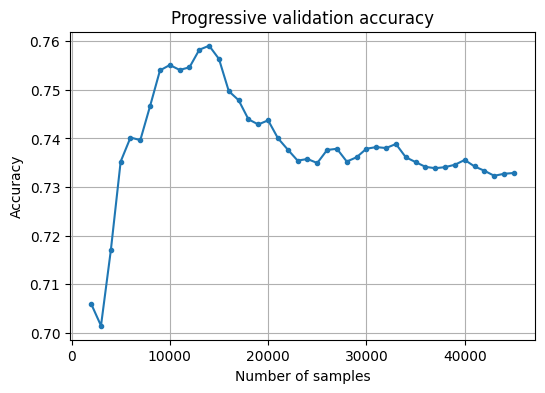

Final accuracy: 0.742597941866763
Normalized AUC: 0.7426775650192494


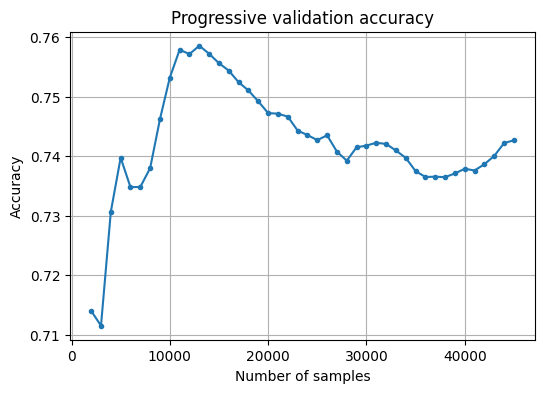

In [15]:
models_syn = [tree.HoeffdingTreeClassifier(), tree.HoeffdingAdaptiveTreeClassifier()]

for model in models_syn:
          train_evaluate(syn_stream,model)

Final accuracy: 0.7940964072937353
Normalized AUC: 0.8170760153620857


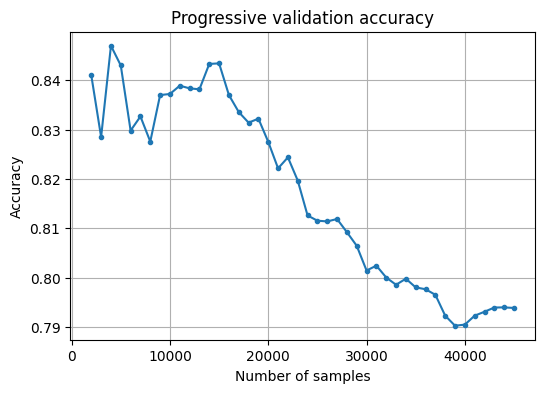

Final accuracy: 0.8324155984834808
Normalized AUC: 0.849592613107435


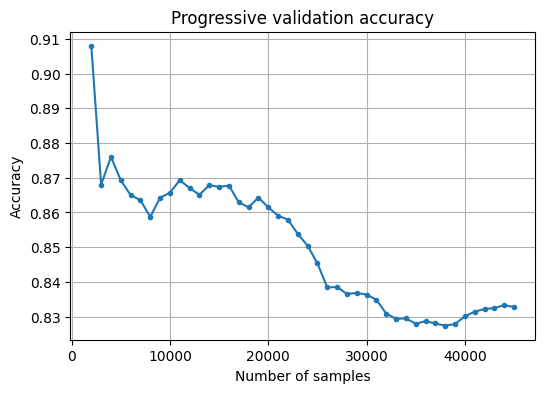

In [16]:
models_elec = [tree.HoeffdingTreeClassifier(), tree.HoeffdingAdaptiveTreeClassifier()]

for model in models_elec:
          train_evaluate(elec,model)